In this notebook can be seen different approaches for games tags analysis

In [194]:
import pandas as pd
import json
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from gensim.models import Word2Vec
import warnings
import random as rnd
rnd.seed(1337)

from scipy.sparse.linalg import svds
from scipy.sparse import coo_matrix
from scipy.stats import pearsonr

import time
from threading import Thread
from numba import njit

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity

warnings.simplefilter('ignore')

In [2]:
# Time in hours
games_main_info = pd.read_csv('games_stats/games_main_info.csv', parse_dates=[3])
games_tags = pd.read_csv('games_stats/games_tags.csv')
games_genres = pd.read_csv('games_stats/games_genres.csv')
users_slice = pd.read_csv('100000_users_slice.csv.gz', compression='gzip')
#playtime_n_players_1 = pd.read_csv('games_stats/playtime_n_players_1.csv')
playtime_n_players_2 = pd.read_csv('games_stats/playtime_n_players_2.csv')

In [93]:
def join_seq(arr, col):
    df = arr[0]
    for el in arr[1:]:
        df = pd.merge(df, el, on=col, how='left')
    return df

def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
games_genres['genre'] += ', '
games_genres = games_genres.groupby('appid').sum().reset_index()
df = join_seq([games_main_info, playtime_n_players_2, games_genres, games_tags], 'appid')
df['tags'] = df['genre']+df['tags']
df = df.drop(['genre'], axis=1)
df['tags'] = df['tags'].fillna('')
df = df.fillna(0)
df['tags'] = df['tags'].apply(lambda x: list(filter(lambda x: not x == '', list(set(x.split(', '))))))
df.head()

,appid,title,price,release_date,rating,required_age,is_multiplayer,n_players_non_zero,summary_playtime,tags
0,414120,Modbox,14.99,2016-04-05,-1,0,0,0.0,0.0000,"[Indie, Multiplayer, VR, Casual, Early Access,..."
1,363020,IPackThat,64.99,2015-10-06,-1,0,0,0.0,0.0000,"[Animation & Modeling, Utilities]"
2,374050,Infinium Strike,0.00,2016-07-14,-1,0,0,0.0,0.0000,"[Indie, Space, Casual, Action, Strategy, Tower..."
3,306410,Crystals of Time,4.99,2014-06-13,-1,0,0,2636.0,7596.3167,"[Adventure, Indie, Casual, Singleplayer, Puzzl..."
4,363050,Let's Explore the Airport (Junior Field Trips),6.99,2015-04-24,-1,0,0,0.0,0.0000,"[Education, Casual, Family Friendly]"


# 1. Simple correlation approach
The main idea of this group of approaches is to take historical data, aggregate them by user and look at correlation between tags. It can let us know if one tag has any relations with others. 
### 1.1. Counter corrleation
The easiest approach is to count each non-zero (it means that users played some game with certain tag at least a minute) tag by user and look at correlation between counts

In [5]:
users_slice = users_slice[['steamid', 'appid', 'playtime_forever']]
users_slice = users_slice.merge(df[['appid', 'tags']], on='appid', how='left')
users_slice = users_slice.dropna().reset_index(drop=True)

In [6]:
mlp = MultiLabelBinarizer()
users_slice = users_slice.join(pd.DataFrame(mlp.fit_transform(users_slice.pop('tags')), columns=mlp.classes_))
users_slice.head()

,steamid,appid,playtime_forever,1980s,1990s,2.5D,2D,2D Fighter,2D Platformer,3D,...,Warhammer 40K,Web Publishing,Well-Written,Werewolves,Western,Word Game,World War I,World War II,Zombies,eSports
0,76561197960265755,10,52,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,76561197960265755,240,1771,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,76561197960265756,10,22054,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,76561197960265756,20,2743,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,76561197960265756,220,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [7]:
gby = users_slice.groupby('steamid')
aggregated_df = gby[users_slice.columns[3]].sum().reset_index()
for i in tqdm_notebook(range(4, users_slice.shape[1])):
    aggregated_df = aggregated_df.merge(gby[users_slice.columns[i]].sum().reset_index(), on='steamid', how='left')
aggregated_df.head()

,steamid,1980s,1990s,2.5D,2D,2D Fighter,2D Platformer,3D,3D Fighter,3D Platformer,...,Warhammer 40K,Web Publishing,Well-Written,Werewolves,Western,Word Game,World War I,World War II,Zombies,eSports
0,76561197960265730,1,6,0,10,0,0,0,0,2,...,0,0,0,0,0,0,1,1,5,4
1,76561197960265731,0,0,0,4,0,1,1,0,3,...,0,0,0,0,0,0,0,1,2,2
2,76561197960265733,1,7,0,8,0,0,3,0,3,...,0,0,0,0,0,0,1,2,8,4
3,76561197960265735,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
4,76561197960265738,2,2,0,14,0,0,1,0,3,...,0,0,0,0,0,0,0,0,3,4


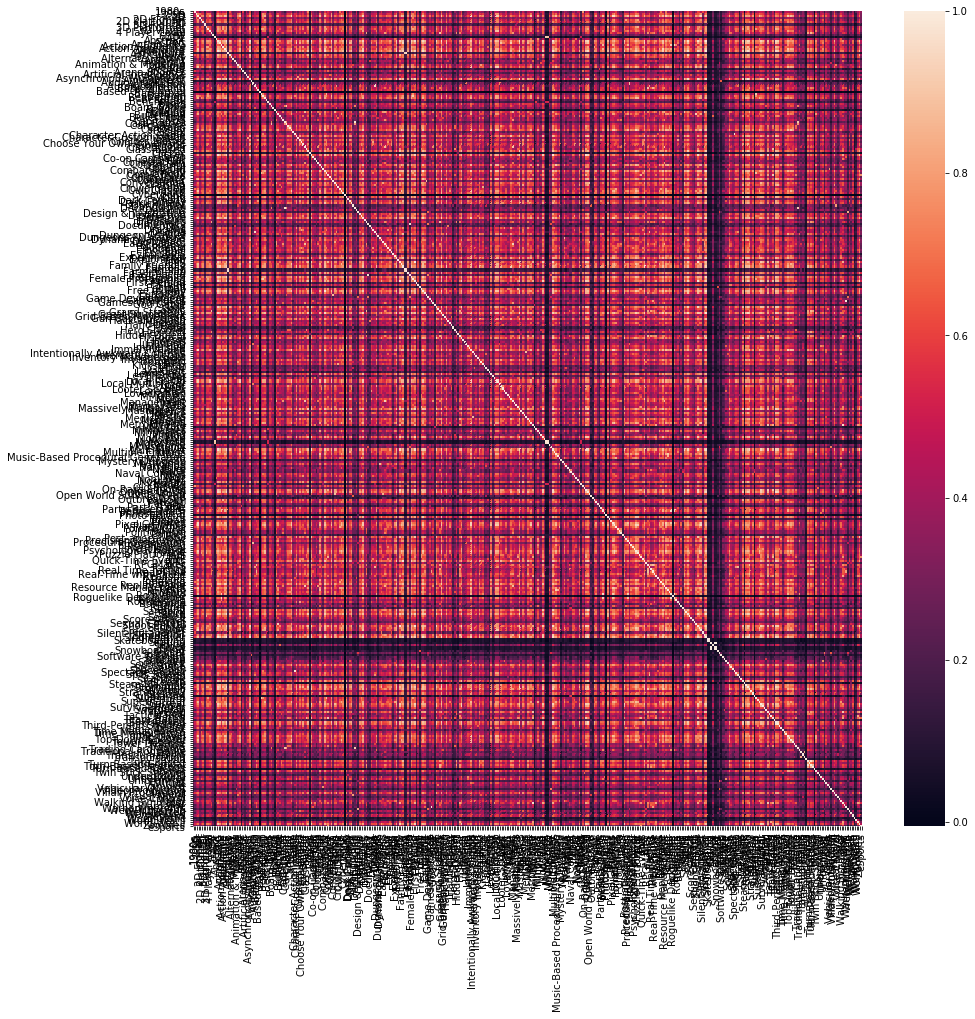

In [8]:
corr = aggregated_df.drop('steamid', axis=1).corr().fillna(-1)
plt.figure(figsize=(15,15))
sns.heatmap(corr,
           xticklabels=corr.columns,
           yticklabels=corr.columns)

Here are couple examples of the most correlated tags for different tags. Let's, firstly, look at different sports tags:

In [9]:
results_dict = {}
results_dict['Sports'] = [corr['Sports'].sort_values(ascending=False)[1:11]]
corr['Sports'].sort_values(ascending=False)[1:11]

Racing               0.869561
Driving              0.765718
Arcade               0.761450
Local Multiplayer    0.736569
Split Screen         0.725427
Funny                0.724156
Action               0.720377
Automobile Sim       0.719989
Controller           0.717727
Multiplayer          0.716265
Name: Sports, dtype: float64

Well, 'Sports' tag do not correlate well with different types of sport such as Footbal, Basketball, Soccer, etc. However, this tag has pretty strong link with 'Racing' and 'Driving'.

In [10]:
results_dict['Skateboarding'] = [corr['Skateboarding'].sort_values(ascending=False)[2:12]]
corr['Skateboarding'].sort_values(ascending=False)[:11]

Skateboarding        1.000000
Skating              1.000000
Local Multiplayer    0.138074
Pixel Graphics       0.135986
Platformer           0.134883
Arcade               0.134478
Side Scroller        0.133980
2D                   0.130786
Local Co-Op          0.130254
Sports               0.129556
Action Roguelike     0.127449
Name: Skateboarding, dtype: float64

In [11]:
results_dict['Snowboarding'] = [corr['Snowboarding'].sort_values(ascending=False)[3:13]]
corr['Snowboarding'].sort_values(ascending=False)[:13]

Snowboarding      1.000000
Snow              1.000000
Skiing            1.000000
VR                0.193419
Sports            0.185399
Early Access      0.157815
Racing            0.153644
Driving           0.143548
Realistic         0.141482
Simulation        0.141041
Automobile Sim    0.130251
Sandbox           0.128809
Level Editor      0.128518
Name: Snowboarding, dtype: float64

In [12]:
results_dict['Football'] = [corr['Football'].sort_values(ascending=False)[1:11]]
corr['Football'].sort_values(ascending=False)[:11]

Football               1.000000
Soccer                 0.617107
Tabletop               0.429648
Board Game             0.302025
Turn-Based             0.278049
Turn-Based Strategy    0.273424
Sports                 0.263187
Strategy               0.247464
Indie                  0.237863
Games Workshop         0.232914
Simulation             0.230680
Name: Football, dtype: float64

In [13]:
results_dict['Basketball'] = [corr['Basketball'].sort_values(ascending=False)[1:11]]
corr['Basketball'].sort_values(ascending=False)[:11]

Basketball       1.000000
Soccer           0.077908
Football         0.053296
Politics         0.041117
Colony Sim       0.040265
Capitalism       0.039974
Sports           0.038592
Economy          0.037993
Political Sim    0.037133
Management       0.037115
Simulation       0.036957
Name: Basketball, dtype: float64

Well, it can be seen that 'Skateboarding' and 'Skating' are the same, so they can be united as 'Snowboarding', 'Snow' and 'Skiing'. Let's look at other tags:

In [14]:
results_dict['FPS'] = [corr['FPS'].sort_values(ascending=False)[1:11]]
corr['FPS'].sort_values(ascending=False)[:11]

FPS             1.000000
First-Person    0.993188
Shooter         0.982423
Multiplayer     0.941791
Co-op           0.933418
Zombies         0.929141
Online Co-Op    0.926894
Gore            0.923993
Action          0.923518
Atmospheric     0.915323
Horror          0.914683
Name: FPS, dtype: float64

In [15]:
results_dict['Horror'] = [corr['Horror'].sort_values(ascending=False)[1:11]]
corr['Horror'].sort_values(ascending=False)[:11]

Horror             1.000000
Zombies            0.943059
Gore               0.938778
Shooter            0.935349
Atmospheric        0.931897
Survival Horror    0.931089
First-Person       0.930418
Action             0.928118
Adventure          0.926493
Survival           0.917948
Masterpiece        0.916439
Name: Horror, dtype: float64

In [16]:
results_dict['Roguelike'] = [corr['Roguelike'].sort_values(ascending=False)[1:11]]
corr['Roguelike'].sort_values(ascending=False)[:11]

Roguelike                1.000000
Roguelite                0.967827
Perma Death              0.958371
Action Roguelike         0.929091
Procedural Generation    0.910371
Pixel Graphics           0.907115
2D                       0.873718
Indie                    0.861279
Top-Down                 0.846942
Difficult                0.837983
Addictive                0.828056
Name: Roguelike, dtype: float64

### 1.2. Playtime correlation
Here is the same idea, but now we digging deeper and instead of counts we are using playtime.

In [17]:
users_slice = users_slice[['steamid', 'appid', 'playtime_forever']]
users_slice = users_slice.merge(df[['appid', 'tags']], on='appid', how='left')
users_slice = users_slice.dropna().reset_index(drop=True)

In [18]:
tmp = np.zeros((users_slice.shape[0], 421))
tags_ids = {col:i for i, col in enumerate(list(set(df['tags'].sum())))}
for i, (playtime, tags) in tqdm_notebook(enumerate(users_slice[['playtime_forever', 'tags']].values)):
    tmp[i, [tags_ids[tag] for tag in tags]] = playtime

In [19]:
users_slice = pd.concat((users_slice.drop('tags', axis=1), pd.DataFrame(tmp, columns=list(set(df['tags'].sum())))), axis=1)

In [20]:
gby = users_slice.groupby('steamid')
aggregated_df = gby[users_slice.columns[3]].sum().reset_index()
for i in tqdm_notebook(range(4, users_slice.shape[1])):
    aggregated_df = aggregated_df.merge(gby[users_slice.columns[i]].sum().reset_index(), on='steamid', how='left')
aggregated_df.head()

,steamid,Mouse only,Soundtrack,Baseball,Offroad,Comic Book,Touch-Friendly,Star Trek,Inventory Management,Hacking,...,Post-apocalyptic,Cartoon,Memes,Based On A Novel,Party,Action RTS,Feature Film,Games Workshop,Old School,Music-Based Procedural Generation
0,76561197960265730,0.0,0.0,0.0,0.0,0.0,46.0,626.0,0.0,0.0,...,18.0,1988.0,0.0,0.0,0.0,0.0,0.0,0.0,878.0,0.0
1,76561197960265731,0.0,0.0,0.0,0.0,0.0,3018.0,0.0,0.0,0.0,...,1529.0,2090.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,76561197960265733,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,374.0,1699.0,78.0,0.0,0.0,0.0,1.0,0.0,1198.0,0.0
3,76561197960265735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,549.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,76561197960265738,300.0,0.0,0.0,0.0,0.0,193.0,0.0,0.0,0.0,...,168.0,154.0,623.0,0.0,0.0,0.0,0.0,0.0,12.0,1196.0


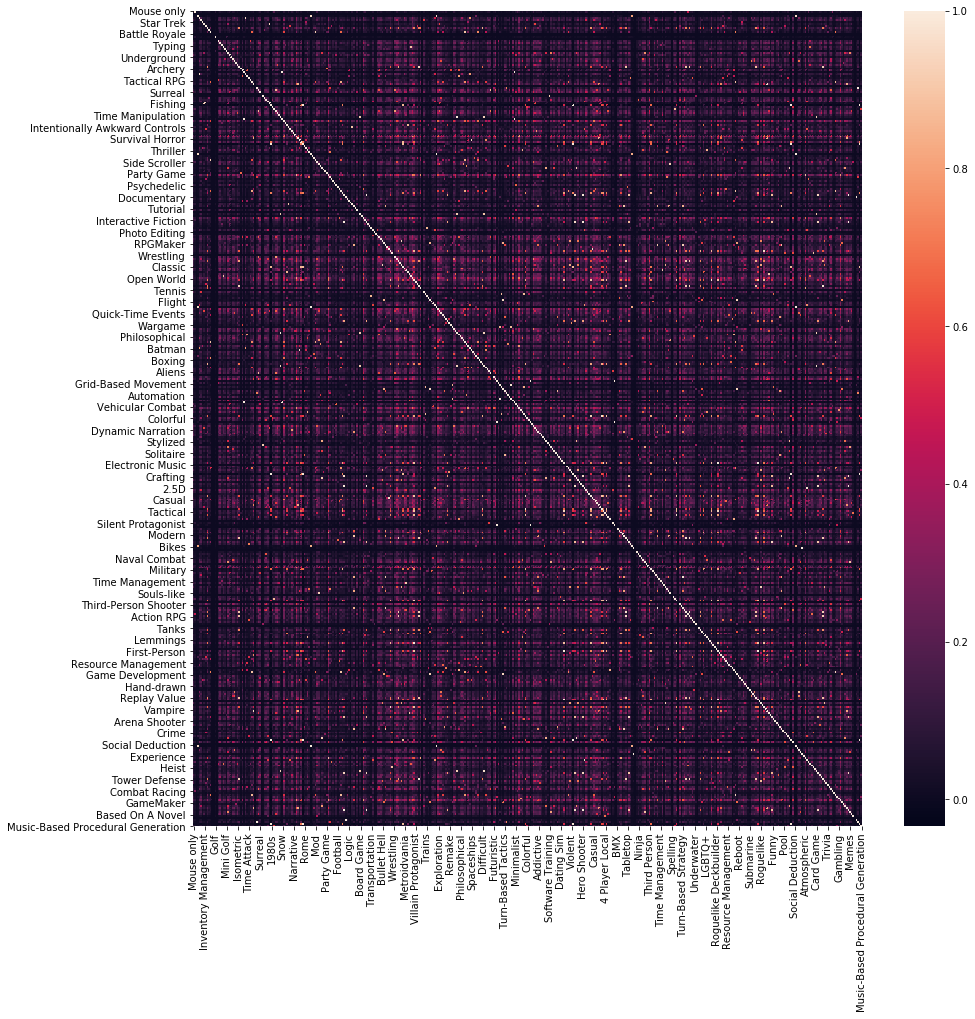

In [232]:
corr = aggregated_df.drop('steamid', axis=1).corr().fillna(0)
plt.figure(figsize=(15,15))
sns.heatmap(corr)

Here are couple examples of the most correlated tags for different tags. Let's, firstly, look at different sports tags:

In [22]:
results_dict['Sports'].append(corr['Sports'].sort_values(ascending=False)[1:11])
corr['Sports'].sort_values(ascending=False)[:11]

Sports            1.000000
Automobile Sim    0.566034
Driving           0.518152
Racing            0.494234
Bikes             0.327385
Offroad           0.257789
Motocross         0.248834
Motorbike         0.248828
ATV               0.246857
Arcade            0.244614
Minigames         0.228207
Name: Sports, dtype: float64

In [23]:
results_dict['Skateboarding'].append(corr['Skateboarding'].sort_values(ascending=False)[2:12])
corr['Skateboarding'].sort_values(ascending=False)[:12]

Skateboarding     1.000000
Skating           1.000000
Roguelite         0.084334
Roguevania        0.081760
Roguelike         0.074979
Perma Death       0.061697
Pixel Graphics    0.053608
2D                0.052862
Experience        0.050884
Metroidvania      0.048758
Surreal           0.042200
Side Scroller     0.041291
Name: Skateboarding, dtype: float64

In [24]:
results_dict['Snowboarding'].append(corr['Snowboarding'].sort_values(ascending=False)[3:13])
corr['Snowboarding'].sort_values(ascending=False)[:13]

Skiing                  1.000000
Snowboarding            1.000000
Snow                    1.000000
Minigames               0.096472
Boxing                  0.074569
Bikes                   0.052456
Sports                  0.050644
Golf                    0.038991
Building                0.036090
Racing                  0.035335
Relaxing                0.033553
Animation & Modeling    0.032439
Beautiful               0.029792
Name: Snowboarding, dtype: float64

In [25]:
results_dict['Football'].append(corr['Football'].sort_values(ascending=False)[1:11])
corr['Football'].sort_values(ascending=False)[:11]

Football                1.000000
Tabletop                0.660254
Board Game              0.215689
Sports                  0.214255
Games Workshop          0.150744
Warhammer 40K           0.149396
Soccer                  0.120239
Turn-Based              0.090099
Turn-Based Strategy     0.087319
Base Building           0.074267
Real-Time with Pause    0.071861
Name: Football, dtype: float64

In [26]:
results_dict['Basketball'].append(corr['Basketball'].sort_values(ascending=False)[1:11])
corr['Basketball'].sort_values(ascending=False)[:11]

Basketball          1.000000
Cycling             0.088065
Modern              0.012225
Martial Arts        0.010585
Dinosaurs           0.010217
Bullet Hell         0.007664
Action Roguelike    0.006338
Parody              0.006240
Co-op Campaign      0.006131
Realistic           0.005555
Fast-Paced          0.005447
Name: Basketball, dtype: float64

Here are some other tags:

In [27]:
results_dict['FPS'].append(corr['FPS'].sort_values(ascending=False)[1:11])
corr['FPS'].sort_values(ascending=False)[:11]

FPS             1.000000
Shooter         0.994276
First-Person    0.993810
Tactical        0.947486
Action          0.884393
Multiplayer     0.883435
Team-Based      0.860662
Military        0.824353
Competitive     0.809292
Survival        0.798843
Strategy        0.733013
Name: FPS, dtype: float64

In [28]:
results_dict['Horror'].append(corr['Horror'].sort_values(ascending=False)[1:11])
corr['Horror'].sort_values(ascending=False)[:11]

Horror                1.000000
Zombies               0.953339
Survival Horror       0.838139
Post-apocalyptic      0.821643
Gore                  0.746140
Local Co-Op           0.712024
Adventure             0.670370
Singleplayer          0.568320
Female Protagonist    0.568017
Controller            0.536008
Co-op                 0.502249
Name: Horror, dtype: float64

In [29]:
results_dict['Roguelike'].append(corr['Roguelike'].sort_values(ascending=False)[1:11])
corr['Roguelike'].sort_values(ascending=False)[:11]

Roguelike                1.000000
Roguelite                0.928066
Perma Death              0.879936
Action Roguelike         0.814411
Procedural Generation    0.806869
Top-Down                 0.767510
Bullet Hell              0.739854
2D                       0.668446
Pixel Graphics           0.542490
Dungeon Crawler          0.531482
Indie                    0.460271
Name: Roguelike, dtype: float64

### 1.3. Games correltaion

In [30]:
users_slice = users_slice[['steamid', 'appid', 'playtime_forever']]
users_slice = users_slice.dropna().reset_index(drop=True)

In [31]:
users_slice[['steamid', 'appid']] = users_slice[['steamid', 'appid']].astype('category')
users_slice.head()

,steamid,appid,playtime_forever
0,76561197960265755,10,52
1,76561197960265755,240,1771
2,76561197960265756,10,22054
3,76561197960265756,20,2743
4,76561197960265756,220,3


In [32]:
users_apps_matrix = coo_matrix((users_slice['playtime_forever']/users_slice['playtime_forever'].max(), 
            (users_slice['steamid'].cat.codes.copy(), 
             users_slice['appid'].cat.codes.copy()))).toarray()

In [33]:
steamid_idx = pd.DataFrame({'steamid':users_slice['steamid'].unique().categories, 'idx':users_slice['steamid'].unique().codes}).sort_values('idx')
appid_idx = pd.DataFrame({'appid':users_slice['appid'].unique().categories, 'idx':users_slice['appid'].unique().codes}).sort_values('idx')

In [34]:
users_apps_df = pd.DataFrame(users_apps_matrix, columns=appid_idx['appid'], index=steamid_idx['steamid'])
users_apps_df.head()

appid,10,240,20,220,500,570,730,24960,70,440,...,263800,298220,31820,244830,252830,243580,313960,292380,285130,278850
steamid,,,,,,,,,,,,,,,,,,,,,
76561197960265755,0.000741,0.000024,0.000008,0.000004,0.000002,0.000000,0.000357,0.000005,0.000009,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960265756,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960265818,0.000987,0.000009,0.000052,0.000008,0.000008,0.000004,0.001429,0.000010,0.000129,8.855027e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960265993,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960265876,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,0.000000,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
apps_corr = users_apps_df.corr()

Oops, It takes too much time, so, I postponed it :)

### Correlation approaches summary


In [119]:
print('Top 10 Count correlations and Playtime correlations respectively:\n')
for key in results_dict.keys():
    tmp = list(map(lambda x: str(x).split('\n')[:-1], results_dict[key]))
    print('--------------------------{}-----------------------------'.format(key))
    for el in list(zip(tmp[0], tmp[1])):
        print(el[0], '  |  ', el[1])
    print()

Top 10 Count correlations and Playtime correlations respectively:

--------------------------Sports-----------------------------
Racing               0.869561   |   Automobile Sim    0.566034
Driving              0.765718   |   Driving           0.518152
Arcade               0.761450   |   Racing            0.494234
Local Multiplayer    0.736569   |   Bikes             0.327385
Split Screen         0.725427   |   Offroad           0.257789
Funny                0.724156   |   Motocross         0.248834
Action               0.720377   |   Motorbike         0.248828
Automobile Sim       0.719989   |   ATV               0.246857
Controller           0.717727   |   Arcade            0.244614
Multiplayer          0.716265   |   Minigames         0.228207

--------------------------Skateboarding-----------------------------
Local Multiplayer    0.138074   |   Roguelite         0.084334
Pixel Graphics       0.135986   |   Roguevania        0.081760
Platformer           0.134883   |   Roguelike

# 2. Matrix Factorization
### 2.1. Counter MF

In [35]:
users_slice = users_slice[['steamid', 'appid', 'playtime_forever']]
users_slice = users_slice.merge(df[['appid', 'tags']], on='appid', how='left')
users_slice = users_slice.dropna().reset_index(drop=True)

In [37]:
mlp = MultiLabelBinarizer()
users_slice = users_slice.join(pd.DataFrame(mlp.fit_transform(users_slice.pop('tags')), columns=mlp.classes_))
users_slice.head()

,steamid,appid,playtime_forever,1980s,1990s,2.5D,2D,2D Fighter,2D Platformer,3D,...,Warhammer 40K,Web Publishing,Well-Written,Werewolves,Western,Word Game,World War I,World War II,Zombies,eSports
0,76561197960265755,10,52,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,76561197960265755,240,1771,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,76561197960265756,10,22054,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,76561197960265756,20,2743,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,76561197960265756,220,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [41]:
gby = users_slice.groupby('steamid')
aggregated_df = gby[users_slice.columns[3]].sum().reset_index()
for i in tqdm_notebook(range(4, users_slice.shape[1])):
    tmp = gby[users_slice.columns[i]].sum().reset_index()
    aggregated_df = aggregated_df.merge(tmp, on='steamid', how='left')
aggregated_df.head()

,steamid,1980s,1990s,2.5D,2D,2D Fighter,2D Platformer,3D,3D Fighter,3D Platformer,...,Warhammer 40K,Web Publishing,Well-Written,Werewolves,Western,Word Game,World War I,World War II,Zombies,eSports
0,76561197960265730,1,6,0,10,0,0,0,0,2,...,0,0,0,0,0,0,1,1,5,4
1,76561197960265731,0,0,0,4,0,1,1,0,3,...,0,0,0,0,0,0,0,1,2,2
2,76561197960265733,1,7,0,8,0,0,3,0,3,...,0,0,0,0,0,0,1,2,8,4
3,76561197960265735,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
4,76561197960265738,2,2,0,14,0,0,1,0,3,...,0,0,0,0,0,0,0,0,3,4


In [74]:
aggregated_df.shape

(99938, 403)

In [69]:
aggregated_mtrx_sparse = coo_matrix(aggregated_df.iloc[:, 1:].values)
non_zero_idx = list(zip(aggregated_mtrx_sparse.row, aggregated_mtrx_sparse.col, aggregated_mtrx_sparse.data))
rnd.shuffle(non_zero_idx)

In [154]:
validation = np.array(list(map(lambda x: [x[0], x[1], x[2]], non_zero_idx[:int(len(non_zero_idx)*0.1)])))
train = np.array(list(map(lambda x: [x[0], x[1], x[2]], non_zero_idx[int(len(non_zero_idx)*0.1):])))

In [155]:
validation.max(axis=0)

array([99937,   401,   681])

In [156]:
train.max(axis=0)

array([99937,   401,   750])

In [167]:
print('Validation set size:', validation.shape[0])

Validation set size: 741338


Fine, both sets have max idx in both directions. Let's evaluate SVD

In [173]:
train_sparse = coo_matrix((train[:, 2].astype(float),(
    train[:, 0], train[:, 1]
)
))

# Collect scores for different parametres
ks = []
scores = {
    'MAPE': {
        'train': [],
        'val': []
    },
    'RMSE': {
        'train': [],
        'val': []
    },
    'MAE': {
        'train': [],
        'val': []
    },
    'R2': {
        'train': [],
        'val': []
    }
}

for k in tqdm_notebook(range(1, 50, 4)):
    U, s, Vt = svds(train_sparse, k=k)
    new_matrix = np.dot(np.dot(U, np.diag(s)), Vt)

    train_hat = []
    for row, col in train[:, :-1]:
        train_hat.append(new_matrix[row, col])

    validation_hat = []
    for row, col in validation[:, :-1]:
        validation_hat.append(new_matrix[row, col])
        
    train_hat = np.array(train_hat)
    validation_hat = np.array(validation_hat)
    train_hat[train_hat < 0] = 0
    validation_hat[validation_hat < 0] = 0
        
    ks.append(k)
    
    scores['MAPE']['train'].append(MAPE(train[:, -1], train_hat))
    scores['MAPE']['val'].append(MAPE(validation[:, -1], validation_hat))
    
    scores['RMSE']['train'].append(mean_squared_error(train[:, -1], train_hat)**0.5)
    scores['RMSE']['val'].append(mean_squared_error(validation[:, -1], validation_hat)**0.5)
    
    scores['MAE']['train'].append(mean_absolute_error(train[:, -1], train_hat))
    scores['MAE']['val'].append(mean_absolute_error(validation[:, -1], validation_hat))
    
    scores['R2']['train'].append(r2_score(train[:, -1], train_hat))
    scores['R2']['val'].append(r2_score(validation[:, -1], validation_hat))

In [217]:
k = 128
U, s, Vt = svds(train_sparse, k=k)

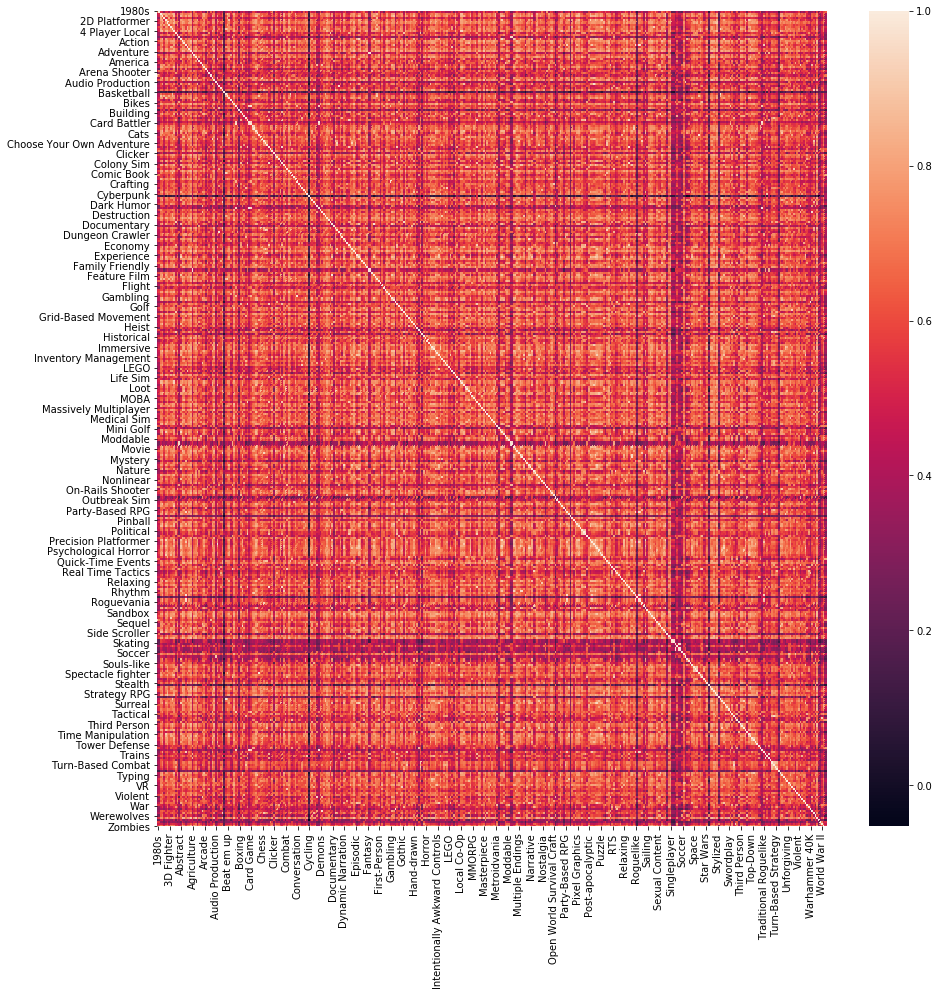

In [220]:
plt.figure(figsize=(15, 15))
sns.heatmap(pd.DataFrame(cosine_similarity(Vt.T, Vt.T), columns=aggregated_df.columns[1:], index=aggregated_df.columns[1:]))

In [223]:
k = 2
U, s, Vt = svds(train_sparse, k=k)

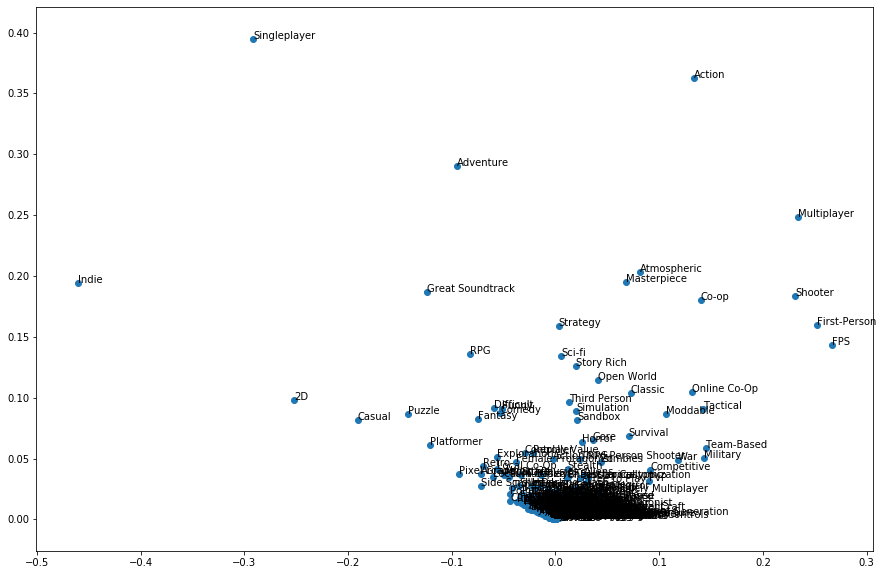

In [227]:
plt.figure(figsize=(15, 10))
plt.scatter(Vt.T[:, 0], Vt.T[:, 1])
for label, x, y in list(zip(aggregated_df.columns[1:], Vt.T[:, 0], Vt.T[:, 1])):
    plt.annotate(label, xy=(x, y))

It seems similar to our correlation approaches, so, they can be used in the future in ensembles.

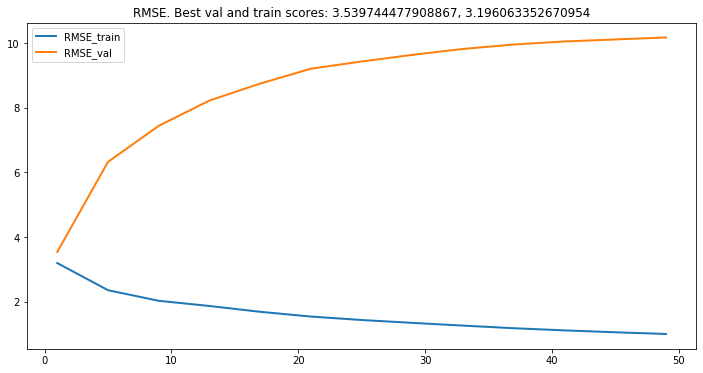

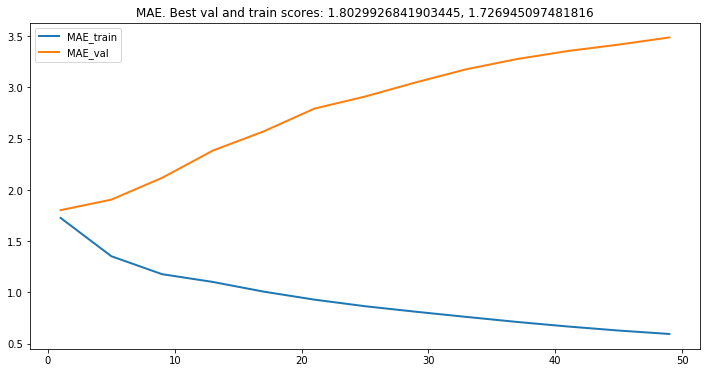

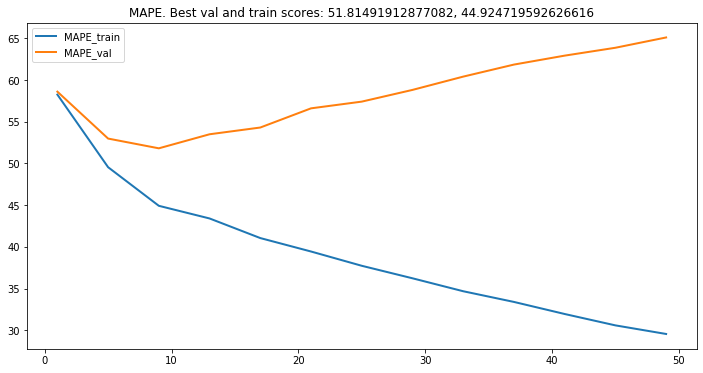

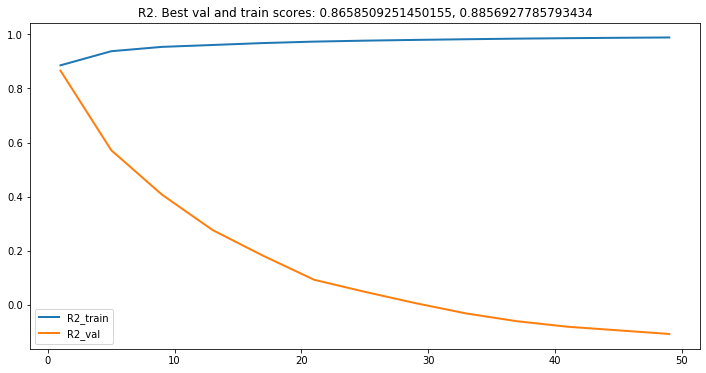

In [226]:
plt.figure(figsize=(12, 6))
# RMSE
plt.plot(ks, scores['RMSE']['train'], linewidth=2, label='RMSE_train')
plt.plot(ks, scores['RMSE']['val'], linewidth=2, label='RMSE_val')
plt.title('RMSE. Best val and train scores: {}, {}'.format(min(scores['RMSE']['val']), scores['RMSE']['train'][scores['RMSE']['val'].index(min(scores['RMSE']['val']))]))
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
# MAE
plt.plot(ks, scores['MAE']['train'], linewidth=2, label='MAE_train')
plt.plot(ks, scores['MAE']['val'], linewidth=2, label='MAE_val')
plt.title('MAE. Best val and train scores: {}, {}'.format(min(scores['MAE']['val']), scores['MAE']['train'][scores['MAE']['val'].index(min(scores['MAE']['val']))]))
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
# MAPE
plt.plot(ks, scores['MAPE']['train'], linewidth=2, label='MAPE_train')
plt.plot(ks, scores['MAPE']['val'], linewidth=2, label='MAPE_val')
plt.title('MAPE. Best val and train scores: {}, {}'.format(min(scores['MAPE']['val']), scores['MAPE']['train'][scores['MAPE']['val'].index(min(scores['MAPE']['val']))]))
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
# R2
plt.plot(ks, scores['R2']['train'], linewidth=2, label='R2_train')
plt.plot(ks, scores['R2']['val'], linewidth=2, label='R2_val')
plt.title('R2. Best val and train scores: {}, {}'.format(max(scores['R2']['val']), scores['R2']['train'][scores['R2']['val'].index(max(scores['R2']['val']))]))
plt.legend()
plt.show()

Well, without any transformations with simple SVD can be riched 0.86 R2 score on validation dataset. Here is one strange thing: more factors we take, worse result we get. So, the best factor in this case is 1, however, it must be evaluated much better than I did, for example, via KFolds, but it is just raw idea and I will leave it like this :) 
### 2.2. Playtime MF

In [229]:
users_slice = users_slice[['steamid', 'appid', 'playtime_forever']]
users_slice = users_slice.merge(df[['appid', 'tags']], on='appid', how='left')
users_slice = users_slice.dropna().reset_index(drop=True)

In [230]:
tmp = np.zeros((users_slice.shape[0], 421))
tags_ids = {col:i for i, col in enumerate(list(set(df['tags'].sum())))}
for i, (playtime, tags) in tqdm_notebook(enumerate(users_slice[['playtime_forever', 'tags']].values)):
    tmp[i, [tags_ids[tag] for tag in tags]] = playtime

In [233]:
users_slice = pd.concat((users_slice.drop('tags', axis=1), pd.DataFrame(tmp, columns=list(set(df['tags'].sum())))), axis=1)

In [234]:
gby = users_slice.groupby('steamid')
aggregated_df = gby[users_slice.columns[3]].sum().reset_index()
for i in tqdm_notebook(range(4, users_slice.shape[1])):
    aggregated_df = aggregated_df.merge(gby[users_slice.columns[i]].sum().reset_index(), on='steamid', how='left')
aggregated_df.head()

,steamid,Mouse only,Soundtrack,Baseball,Offroad,Comic Book,Touch-Friendly,Star Trek,Inventory Management,Hacking,...,Post-apocalyptic,Cartoon,Memes,Based On A Novel,Party,Action RTS,Feature Film,Games Workshop,Old School,Music-Based Procedural Generation
0,76561197960265730,0.0,0.0,0.0,0.0,0.0,46.0,626.0,0.0,0.0,...,18.0,1988.0,0.0,0.0,0.0,0.0,0.0,0.0,878.0,0.0
1,76561197960265731,0.0,0.0,0.0,0.0,0.0,3018.0,0.0,0.0,0.0,...,1529.0,2090.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,76561197960265733,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,374.0,1699.0,78.0,0.0,0.0,0.0,1.0,0.0,1198.0,0.0
3,76561197960265735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,549.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,76561197960265738,300.0,0.0,0.0,0.0,0.0,193.0,0.0,0.0,0.0,...,168.0,154.0,623.0,0.0,0.0,0.0,0.0,0.0,12.0,1196.0


In [235]:
aggregated_mtrx_sparse = coo_matrix(aggregated_df.iloc[:, 1:].values)
non_zero_idx = list(zip(aggregated_mtrx_sparse.row, aggregated_mtrx_sparse.col, aggregated_mtrx_sparse.data))
rnd.shuffle(non_zero_idx)

In [236]:
validation = np.array(list(map(lambda x: [x[0], x[1], x[2]], non_zero_idx[:int(len(non_zero_idx)*0.1)])))
train = np.array(list(map(lambda x: [x[0], x[1], x[2]], non_zero_idx[int(len(non_zero_idx)*0.1):])))

In [237]:
validation.max(axis=0)

array([9.993700e+04, 4.200000e+02, 1.527193e+06])

In [238]:
train.max(axis=0)

array([9.993700e+04, 4.200000e+02, 1.629853e+06])

In [240]:
train = train.astype(int)
validation = validation.astype(int)

In [241]:
train_sparse = coo_matrix((train[:, 2].astype(float),(
    train[:, 0], train[:, 1]
)
))

# Collect scores for different parametres
ks = []
scores = {
    'MAPE': {
        'train': [],
        'val': []
    },
    'RMSE': {
        'train': [],
        'val': []
    },
    'MAE': {
        'train': [],
        'val': []
    },
    'R2': {
        'train': [],
        'val': []
    }
}

for k in tqdm_notebook(range(1, 50, 4)):
    U, s, Vt = svds(train_sparse, k=k)
    new_matrix = np.dot(np.dot(U, np.diag(s)), Vt)

    train_hat = []
    for row, col in train[:, :-1]:
        train_hat.append(new_matrix[row, col])

    validation_hat = []
    for row, col in validation[:, :-1]:
        validation_hat.append(new_matrix[row, col])
        
    train_hat = np.array(train_hat)
    validation_hat = np.array(validation_hat)
    train_hat[train_hat < 0] = 0
    validation_hat[validation_hat < 0] = 0
        
    ks.append(k)
    
    scores['MAPE']['train'].append(MAPE(train[:, -1], train_hat))
    scores['MAPE']['val'].append(MAPE(validation[:, -1], validation_hat))
    
    scores['RMSE']['train'].append(mean_squared_error(train[:, -1], train_hat)**0.5)
    scores['RMSE']['val'].append(mean_squared_error(validation[:, -1], validation_hat)**0.5)
    
    scores['MAE']['train'].append(mean_absolute_error(train[:, -1], train_hat))
    scores['MAE']['val'].append(mean_absolute_error(validation[:, -1], validation_hat))
    
    scores['R2']['train'].append(r2_score(train[:, -1], train_hat))
    scores['R2']['val'].append(r2_score(validation[:, -1], validation_hat))

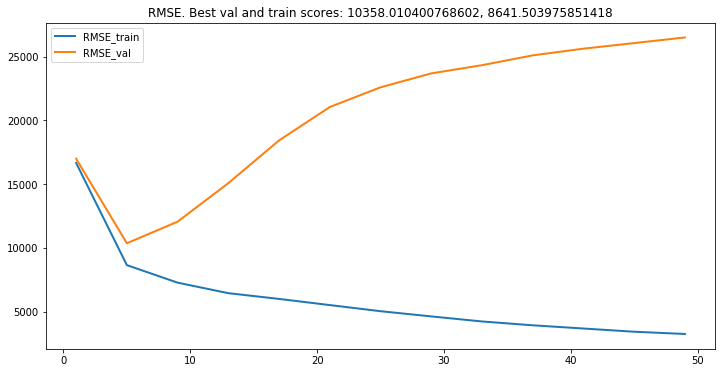

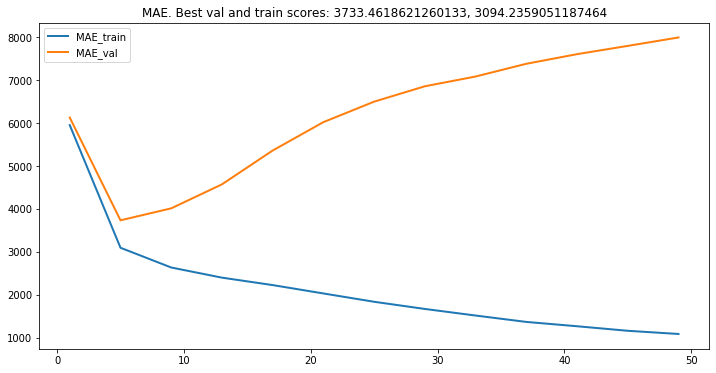

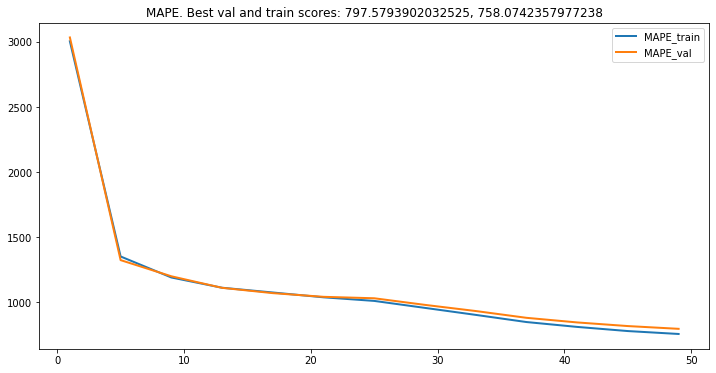

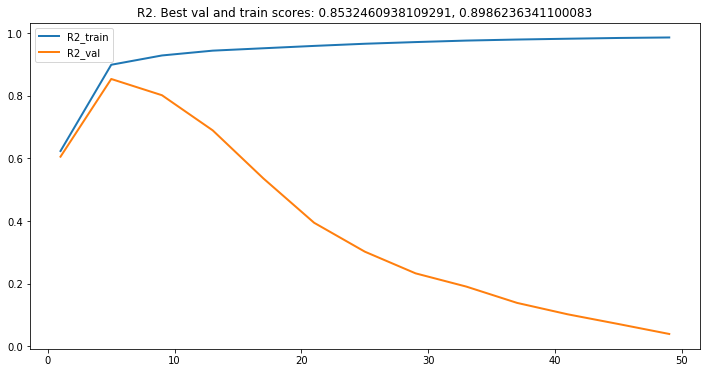

In [242]:
plt.figure(figsize=(12, 6))
# RMSE
plt.plot(ks, scores['RMSE']['train'], linewidth=2, label='RMSE_train')
plt.plot(ks, scores['RMSE']['val'], linewidth=2, label='RMSE_val')
plt.title('RMSE. Best val and train scores: {}, {}'.format(min(scores['RMSE']['val']), scores['RMSE']['train'][scores['RMSE']['val'].index(min(scores['RMSE']['val']))]))
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
# MAE
plt.plot(ks, scores['MAE']['train'], linewidth=2, label='MAE_train')
plt.plot(ks, scores['MAE']['val'], linewidth=2, label='MAE_val')
plt.title('MAE. Best val and train scores: {}, {}'.format(min(scores['MAE']['val']), scores['MAE']['train'][scores['MAE']['val'].index(min(scores['MAE']['val']))]))
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
# MAPE
plt.plot(ks, scores['MAPE']['train'], linewidth=2, label='MAPE_train')
plt.plot(ks, scores['MAPE']['val'], linewidth=2, label='MAPE_val')
plt.title('MAPE. Best val and train scores: {}, {}'.format(min(scores['MAPE']['val']), scores['MAPE']['train'][scores['MAPE']['val'].index(min(scores['MAPE']['val']))]))
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
# R2
plt.plot(ks, scores['R2']['train'], linewidth=2, label='R2_train')
plt.plot(ks, scores['R2']['val'], linewidth=2, label='R2_val')
plt.title('R2. Best val and train scores: {}, {}'.format(max(scores['R2']['val']), scores['R2']['train'][scores['R2']['val'].index(max(scores['R2']['val']))]))
plt.legend()
plt.show()

### 2.3. Games counter MF
The idea is to use higher level of MF - games. And then calculate values for tags depending on the values for games.
Coming soon

### 2.4. Games playtime MF
Very similar idea to idea above, but instead of games counts we will use games playtime. Coming soon

# 3. Word2Vec
The idea is to use context-based models (the most popular is Word2Vec) for learning embeddings of tags.

In [243]:
w2v4vis = Word2Vec(df['tags'], size=2)

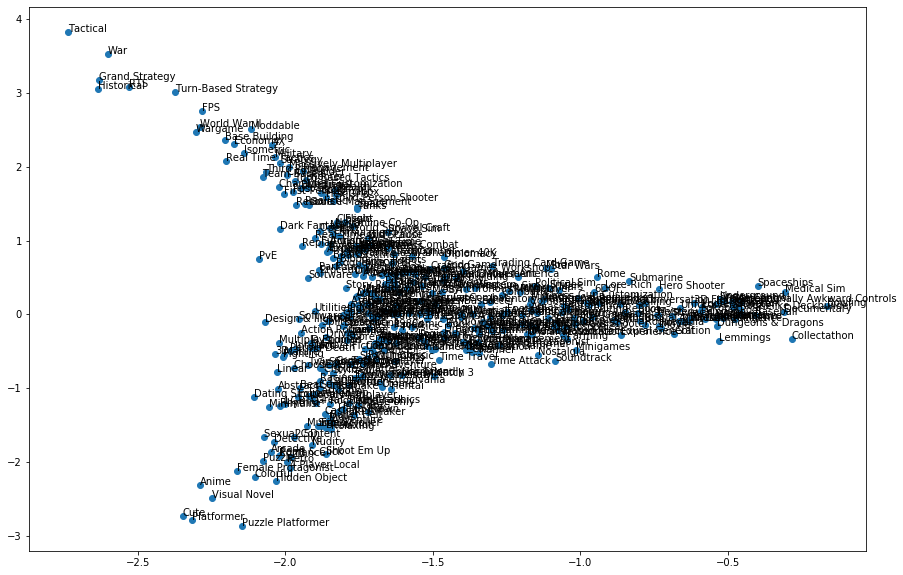

In [250]:
plt.figure(figsize=(15, 10))
plt.scatter(w2v4vis[w2v4vis.wv.vocab.keys()][:, 0], w2v4vis[w2v4vis.wv.vocab.keys()][:, 1])
for label, x, y in list(zip(list(w2v4vis.wv.vocab.keys()), w2v4vis[w2v4vis.wv.vocab.keys()][:, 0], w2v4vis[w2v4vis.wv.vocab.keys()][:, 1])):
    plt.annotate(label, xy=(x, y))
plt.show()

In [251]:
w2v = Word2Vec(df['tags'])

In [253]:
w2v.most_similar('Sports')

[('Racing', 0.9630018472671509),
 ('Automobile Sim', 0.9405933618545532),
 ('Driving', 0.9223954677581787),
 ('Competitive', 0.9113854765892029),
 ('Soccer', 0.8984054327011108),
 ('Top-Down', 0.8949579000473022),
 ('Offroad', 0.8820036053657532),
 ('Arena Shooter', 0.875113844871521),
 ('Bikes', 0.8676506280899048),
 ('4 Player Local', 0.8662786483764648)]

In [254]:
w2v.most_similar('Football')

[('Bikes', 0.9926159381866455),
 ('Soccer', 0.9924213886260986),
 ('Gambling', 0.9887274503707886),
 ('Pool', 0.9876198768615723),
 ('Basketball', 0.9856999516487122),
 ('Offroad', 0.9854249954223633),
 ('Capitalism', 0.983240008354187),
 ('Motorbike', 0.9830265045166016),
 ('Golf', 0.9818963408470154),
 ('Mini Golf', 0.9810395240783691)]

In [255]:
w2v.most_similar('Soccer')

[('Football', 0.9924212694168091),
 ('Offroad', 0.9892772436141968),
 ('Bikes', 0.9877431988716125),
 ('Pool', 0.9780914187431335),
 ('Class-Based', 0.9754123687744141),
 ('Dungeons & Dragons', 0.975216269493103),
 ('Party Game', 0.9733437895774841),
 ('Sailing', 0.9727619886398315),
 ('Capitalism', 0.9723383188247681),
 ('Motorbike', 0.9717259407043457)]

In [256]:
w2v.most_similar('Horror')

[('Walking Simulator', 0.9611026644706726),
 ('Survival Horror', 0.911898136138916),
 ('Adventure', 0.871146023273468),
 ('Psychological', 0.8695803880691528),
 ('Masterpiece', 0.8686449527740479),
 ('Supernatural', 0.8504207134246826),
 ('Dark', 0.8442858457565308),
 ('Point & Click', 0.8411448001861572),
 ('Crime', 0.8321847915649414),
 ('Linear', 0.8321770429611206)]

In [257]:
w2v.most_similar('Roguelike')

[('Procedural Generation', 0.9937162399291992),
 ('Action Roguelike', 0.9707872271537781),
 ('Replay Value', 0.9400883316993713),
 ('Difficult', 0.9295741319656372),
 ('Hack and Slash', 0.9264140129089355),
 ('Action RPG', 0.8935476541519165),
 ('Old School', 0.8880095481872559),
 ('Isometric', 0.8766614198684692),
 ('Character Customization', 0.8600071668624878),
 ('Loot', 0.8588180541992188)]

In [258]:
w2v.most_similar('FPS')

[('Third-Person Shooter', 0.9787856340408325),
 ('First-Person', 0.948967695236206),
 ('Gore', 0.9289547801017761),
 ('Shooter', 0.920569658279419),
 ('Stealth', 0.9178152084350586),
 ('Sci-fi', 0.8929048180580139),
 ('Open World Survival Craft', 0.8863435983657837),
 ('Post-apocalyptic', 0.8835609555244446),
 ('Robots', 0.8772169947624207),
 ('Massively Multiplayer', 0.8754405975341797)]

In [259]:
w2v.most_similar('Indie')

[('Colorful', 0.9877672791481018),
 ('Funny', 0.9638015031814575),
 ('Soundtrack', 0.9168626666069031),
 ('Touch-Friendly', 0.9132007360458374),
 ('3D', 0.908413290977478),
 ('Beautiful', 0.9051828980445862),
 ('Singleplayer', 0.9044226408004761),
 ('4 Player Local', 0.9033986330032349),
 ('Addictive', 0.9014381766319275),
 ('Platformer', 0.9000471234321594)]

In [260]:
w2v.most_similar('Platformer')

[('Puzzle Platformer', 0.9785730838775635),
 ('Retro', 0.9593296051025391),
 ('Music', 0.9388126134872437),
 ('2.5D', 0.9336087703704834),
 ('Colorful', 0.9030262231826782),
 ('Indie', 0.9000471234321594),
 ('Cartoony', 0.8769928812980652),
 ('4 Player Local', 0.8607348203659058),
 ('Shoot Em Up', 0.8575466871261597),
 ('Arcade', 0.8519506454467773)]

# What's next?
Honestly, it is wide task, so, there are a lot of approaches which must be tried. What I wanna try: <br>
1) Try different transformations for MF and different MF algorithms <br>
2) Try to cluster tags in higher level tags for noise removing and analyze them <br>
3) Try to solve this task as Link Prediction task <br>
4) Try to use autoencoders for embeddings creation <br>
5) Find the best way of evaluation <br>